In [41]:
# import networkx as nx
# from parse import read_input_file, write_output_file
# from utils import is_valid_network, average_pairwise_distance
# import os
# import sys
# import matplotlib.pyplot as plt
# import random
# import utils


# def solve(G):
#     """
#     Args:
#         G: networkx.Graph

#     Returns:
#         T: networkx.Graph
#     """

#     T = nx.minimum_spanning_tree(G)
#     if T.number_of_nodes() == 1:
#         return T
#     elif T.number_of_nodes() == 2:
#         node = list(T.nodes)[0]
#         T.remove_node(node)
#         return T
#     else:
#         u_list = []
#         v_list = []
#         v_u_dict = {node:[] for node in T.nodes}
#         for u in T.nodes:
#             if T.degree(u) == 1:
#                 v = list(T.neighbors(u))[0]
#                 u_list.append(u)
#                 v_list.append(v)
#                 v_u_dict[v].append(u)
#         for u in u_list:
#             T.remove_node(u)
#         if len(list(T.nodes)) == 1:
#             return T
#         v_list = list(set(v_list))
#         for v in v_list:
#             copy = T.copy()
#             copy.remove_node(v)
#             if len(list(copy.nodes)) == 0:
#                 return T
#             if is_valid_network(G, copy):
#                 T.remove_node(v)
        
#         # newly added: brute force final deletion check
#         # node_list = list(T.nodes())
#         # for node in node_list:
#         #     copy = T.copy()
#         #     copy.remove_node(node)
#         #     if len(list(copy.nodes)) == 0:
#         #         return T
#         #     if is_valid_network(G, copy):
#         #         T.remove_node(node)
        
#         min_T = T.copy()
#         for i in range(300):
#             copy = T.copy()
#             while is_valid_network(G, copy):
#                 T = copy.copy()
#                 node_list = list(T.nodes())
#                 n = random.choice(node_list)
#                 copy.remove_node(n)

#                 if len(list(copy.nodes)) == 0:
#                     return T
#                 if is_valid_network(G, copy):
#                     if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
#                         min_T = copy.copy()
        
#         return min_T
#         # TODO: your code here!
    


# # Here's an example of how to run your solver.

# # Usage: python3 solver.py test.in

# if __name__ == '__main__':

#     input_folder_path = '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/inputs'
#     for input_file in os.listdir(input_folder_path):
#         print(input_file)
#         full_path = os.path.join(input_folder_path, input_file)
#         G = read_input_file(full_path)
#         T = solve(G)
#         assert is_valid_network(G, T), "T is not a valid network of G."
#         print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#         write_output_file(T, '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/outputs/' + input_file[:-2] + 'out')

#     # path = '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/inputs/large-26.in'
#     # G = read_input_file(path)
#     # T = solve(G)
#     # fig = plt.figure(figsize=(20,30))
#     # fig.add_subplot(211)
#     # pos = nx.spring_layout(G)
#     # nx.draw_networkx(G, pos=pos, node_color='yellow')
#     # nx.draw_networkx(G.subgraph(T.nodes()), pos=pos, node_color='orange', edge_color='red')
#     # assert is_valid_network(G, T), "T is not a valid network of G."
#     # print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#     # write_output_file(T, '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/outputs/' + path[-10:-2] + 'out')


# below is the method using degree heuristic to let MST pick higher-degree nodes

import networkx as nx
from parse import read_input_file, write_output_file, read_output_file
import utils
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import os
import sys
import matplotlib.pyplot as plt
import random
import numpy as np


def solve(G):
    """
    Args:
        G: networkx.Graph

    Returns:
        T: networkx.Graph
    """
    # Special case for one central node
    for node in G.nodes():
        if G.degree(node) == G.number_of_nodes() - 1:
            T = nx.Graph()
            T.add_node(node)
            return T
        
    # added: weight <- weight - degree, to let MST choose higher-degree nodes
    G_copy = G.copy()
    for edge in G_copy.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] /= np.log(1+max(G_copy.degree(u), G_copy.degree(v)))
    T = nx.minimum_spanning_tree(G_copy)
    for edge in T.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] = G[u][v]['weight']
        
    # Add in nodes with eccentricity lower than T's radius to possibly reduce the longest distance between 2 endpoints
    for node in G.nodes():
        if nx.eccentricity(T, node) < nx.radius(T):
            T.add_node(node)
            e = min(G.edges(node), key=lambda x: G[x[0]][x[1]]['weight'])
            T.add_edge(e[0],e[1])
    
    if T.number_of_nodes() == 1:
        return T
    elif T.number_of_nodes() == 2:
        node = list(T.nodes)[0]
        T.remove_node(node)
        return T
    else:
        u_list = []
        v_list = []
        v_u_dict = {node:[] for node in T.nodes}
        for u in T.nodes:
            if T.degree(u) == 1:
                v = list(T.neighbors(u))[0]
                u_list.append(u)
                v_list.append(v)
                v_u_dict[v].append(u)
        for u in u_list:
            T.remove_node(u)
        if len(list(T.nodes)) == 1:
            return T
        v_list = list(set(v_list))
        for v in v_list:
            copy = T.copy()
            copy.remove_node(v)
            if len(list(copy.nodes)) == 0:
                return T
            if is_valid_network(G, copy):
                T.remove_node(v)
        
        # newly added: brute force final deletion check
#         node_list = list(T.nodes())
#         for node in node_list:
#             copy = T.copy()
#             copy.remove_node(node)
#             if len(list(copy.nodes)) == 0:
#                 return T
#             if is_valid_network(G, copy):
#                 T.remove_node(node)
        min_T = T.copy()
        for i in range(300):
            copy = T.copy()
            while is_valid_network(G, copy):
                T = copy.copy()
                node_list = list(T.nodes())
                n = random.choices(node_list)[0]
                copy.remove_node(n)

                if len(list(copy.nodes)) == 0:
                    return T
                if is_valid_network(G, copy):
                    if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
                        min_T = copy.copy()
                        
                        
        # added
#         min_T.remove_edge(20, 21)
#         min_T.add_edge(13, 17)
        
        return min_T
        # TODO: your code here!
    


# Here's an example of how to run your solver.

# Usage: python3 solver.py test.in

if __name__ == '__main__':

    input_folder_path = 'inputs'
    for input_file in os.listdir(input_folder_path):
        print(input_file)
        full_path = os.path.join(input_folder_path, input_file)
        G = read_input_file(full_path)
        T = solve(G)
        assert is_valid_network(G, T), "T is not a valid network of G."
        # Compare previous result with new result, update if improvement seen
        old = read_output_file('outputs/' + input_file[:-2] + 'out', G)
        dist_old = average_pairwise_distance_fast(old)
        dist_new = average_pairwise_distance_fast(T)
        print("Old Average  pairwise distance: {}".format(dist_old))
        print("New Average  pairwise distance: {}".format(dist_new))
        if dist_old > dist_new:
            write_output_file(T, 'outputs/' + input_file[:-2] + 'out')

#     path = 'inputs/large-10.in'
#     G = read_input_file(path)
#     T = solve(G)
#     fig = plt.figure(figsize=(20,30))
#     fig.add_subplot(211)
#     pos = nx.spring_layout(G)
    
#     labels = nx.get_edge_attributes(G,'weight')
    
#     nx.draw_networkx(G, pos=pos, node_color='yellow')
#     nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='orange', edge_color='yellow')
#     # nx.draw_networkx(T, pos=pos, node_color='yellow')
#     #nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
#     assert is_valid_network(G, T), "T is not a valid network of G."
#     print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#     write_output_file(T, 'outputs/' + path[-10:-2] + 'out')
        
    
    
    


large-1.in
Old Average  pairwise distance: 62.40203761755486
New Average  pairwise distance: 62.40203761755486
large-10.in
Old Average  pairwise distance: 3.206952380952381
New Average  pairwise distance: 3.7096785714285714
large-100.in
Old Average  pairwise distance: 99.9
New Average  pairwise distance: 99.9
large-101.in
Old Average  pairwise distance: 34.5668253968254
New Average  pairwise distance: 34.5668253968254
large-102.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
large-103.in
Old Average  pairwise distance: 0.9171666666666667
New Average  pairwise distance: 0.9171666666666667
large-104.in
Old Average  pairwise distance: 26.223744615384618
New Average  pairwise distance: 26.223744615384618
large-105.in
Old Average  pairwise distance: 2.719666666666667
New Average  pairwise distance: 3.103133333333333
large-106.in
Old Average  pairwise distance: 32.140181818181816
New Average  pairwise distance: 32.140181818181816
large-107.in
Old Average  pairwise dist

KeyboardInterrupt: 

In [24]:
    temp = read_output_file('outputs/large-102.out', G)
    nx.draw_networkx(G, pos=pos, node_color='yellow')
    nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='orange', edge_color='yellow')
    print("Average  pairwise distance: {}".format(average_pairwise_distance(temp)))

AssertionError: 

Average  pairwise distance: 166.4746153846154


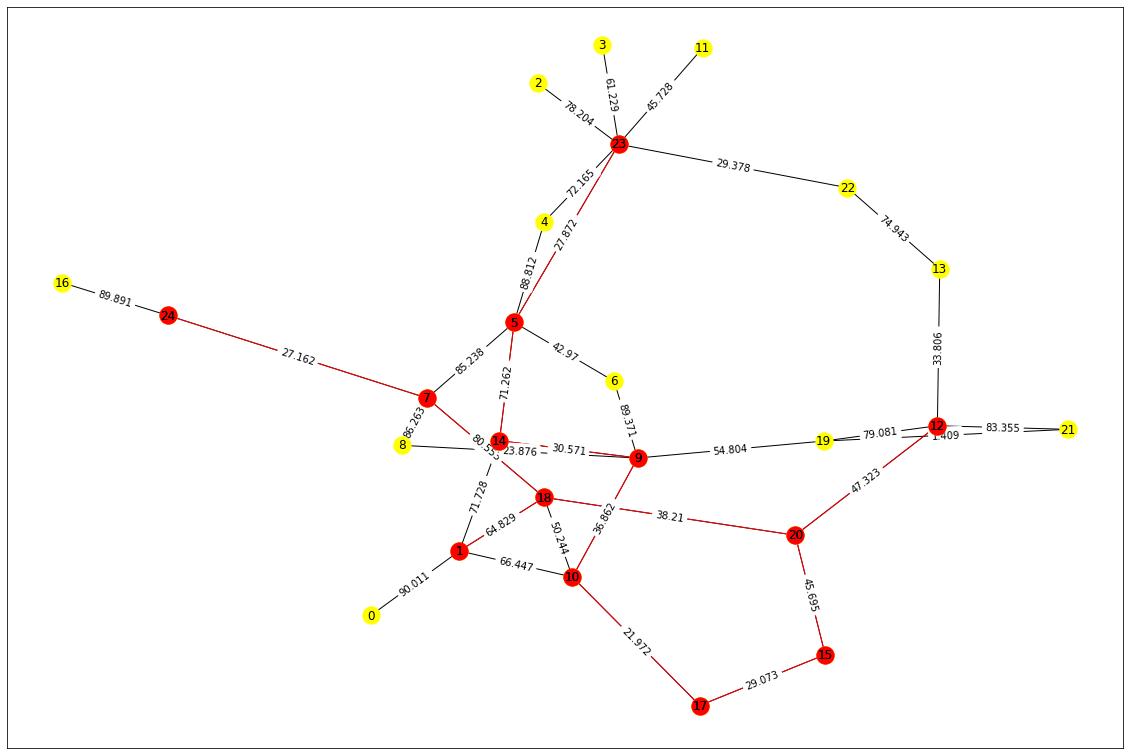

In [68]:
# import networkx as nx
# from parse import read_input_file, write_output_file
# from utils import is_valid_network, average_pairwise_distance
# import os
# import sys
# import matplotlib.pyplot as plt
# import random
# import utils


# def solve(G):
#     """
#     Args:
#         G: networkx.Graph

#     Returns:
#         T: networkx.Graph
#     """

#     T = nx.minimum_spanning_tree(G)
#     if T.number_of_nodes() == 1:
#         return T
#     elif T.number_of_nodes() == 2:
#         node = list(T.nodes)[0]
#         T.remove_node(node)
#         return T
#     else:
#         u_list = []
#         v_list = []
#         v_u_dict = {node:[] for node in T.nodes}
#         for u in T.nodes:
#             if T.degree(u) == 1:
#                 v = list(T.neighbors(u))[0]
#                 u_list.append(u)
#                 v_list.append(v)
#                 v_u_dict[v].append(u)
#         for u in u_list:
#             T.remove_node(u)
#         if len(list(T.nodes)) == 1:
#             return T
#         v_list = list(set(v_list))
#         for v in v_list:
#             copy = T.copy()
#             copy.remove_node(v)
#             if len(list(copy.nodes)) == 0:
#                 return T
#             if is_valid_network(G, copy):
#                 T.remove_node(v)

#         # newly added: brute force final deletion check
#         # node_list = list(T.nodes())
#         # for node in node_list:
#         #     copy = T.copy()
#         #     copy.remove_node(node)
#         #     if len(list(copy.nodes)) == 0:
#         #         return T
#         #     if is_valid_network(G, copy):
#         #         T.remove_node(node)

#         min_T = T.copy()
#         for i in range(300):
#             copy = T.copy()
#             while is_valid_network(G, copy):
#                 T = copy.copy()
#                 node_list = list(T.nodes())
#                 n = random.choice(node_list)
#                 copy.remove_node(n)

#                 if len(list(copy.nodes)) == 0:
#                     return T
#                 if is_valid_network(G, copy):
#                     if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
#                         min_T = copy.copy()

#         return min_T
#         # TODO: your code here!


# # Here's an example of how to run your solver.

# # Usage: python3 solver.py test.in

# if __name__ == '__main__':

#     input_folder_path = '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/inputs'
#     for input_file in os.listdir(input_folder_path):
#         print(input_file)
#         full_path = os.path.join(input_folder_path, input_file)
#         G = read_input_file(full_path)
#         T = solve(G)
#         assert is_valid_network(G, T), "T is not a valid network of G."
#         print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#         write_output_file(T, '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/outputs/' + input_file[:-2] + 'out')

#     # path = '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/inputs/large-26.in'
#     # G = read_input_file(path)
#     # T = solve(G)
#     # fig = plt.figure(figsize=(20,30))
#     # fig.add_subplot(211)
#     # pos = nx.spring_layout(G)
#     # nx.draw_networkx(G, pos=pos, node_color='yellow')
#     # nx.draw_networkx(G.subgraph(T.nodes()), pos=pos, node_color='orange', edge_color='red')
#     # assert is_valid_network(G, T), "T is not a valid network of G."
#     # print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#     # write_output_file(T, '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/outputs/' + path[-10:-2] + 'out')


# below is the method using degree heuristic to let MST pick higher-degree nodes

import networkx as nx
from parse import read_input_file, write_output_file, read_output_file
import utils
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import os
import sys
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools


def bruteforce(G):
    list_of_trees = []
    min_dist = 1000000
    minT = nx.Graph()
    # Remove degree 1 nodes and add their neighbors to minT
    def traverse(T, G, G_copy):
        nonlocal min_dist
        nonlocal minT
        if G_copy.number_of_edges() == 0:
            return
        for e in G_copy.edges():
            u, v = e[0], e[1]
            if e in T.edges():
                continue
            copy = T.copy()
            temp = G_copy.copy()
            T.add_node(u)
            T.add_node(v)
            T.add_edge(v, u, weight= G[v][u]['weight'])
            temp.remove_edge(u, v)
            if is_valid_network(G, T):
                if average_pairwise_distance_fast(T) < min_dist:
                    min_dist = average_pairwise_distance_fast(T)
                    minT = T.copy()
                traverse(T, G, temp)
            elif not nx.is_dominating_set(G, T.nodes()) or not nx.is_connected(T):
                traverse(T, G, temp)
            T = copy.copy()

    def findChain(G):
        nonlocal confirmed
        nonlocal T
        nonlocal G_copy
        changed = False
        nodes = [n for n in G.nodes()]
        for v in nodes:
            if G.degree(v) == 1:
                u = list(G.neighbors(v))[0]
                confirmed.append(u)
                T.add_node(u)
                if u in confirmed and v in confirmed:
                    T.add_edge(u, v, weight=G[u][v]['weight'])
                    G_copy.remove_edge(u,v)
                G.remove_node(v)
                changed = True
        if changed:
            findChain(G)

    def remove(copy, G_copy, k):
        nonlocal min_dist
        nonlocal minT
        has_valid = False
        for c in itertools.combinations(G_copy.edges(), k):
            temp = copy.copy()
            for e in c:
                u, v = e[0], e[1]
                if copy.degree(u) == 1:
                    copy.remove_node(u)
                elif copy.degree(v) == 1:
                    copy.remove_node(v)
                else:
                    copy.remove_edge(u, v)
            if is_valid_network(G, copy):
                has_valid = True
                if average_pairwise_distance_fast(copy) < min_dist:
                    min_dist = average_pairwise_distance_fast(copy)
                    minT = copy.copy()
            elif nx.is_dominating_set(G, copy.nodes()) and nx.is_connected(copy):
                has_valid = True
            copy = temp
        if not has_valid:
            return
        remove(copy, G_copy, k+1)
        # if copy.number_of_nodes() == 1:
        #     if is_valid_network(G, copy):
        #         minT = copy
        #     return
        # for e in G_copy.edges():
        #     if e not in copy.edges():
        #         continue
        #     u, v = e[0], e[1]
        #     if copy.degree(u) == 1:
        #         if u in confirmed:
        #             continue
        #         copy.remove_node(u)
        #     elif copy.degree(v) == 1:
        #         if v in confirmed:
        #             continue
        #         copy.remove_node(v)
        #     else:
        #         copy.remove_edge(u, v)
        #     if is_valid_network(G, copy):
        #         if average_pairwise_distance_fast(copy) < min_dist:
        #             min_dist = average_pairwise_distance_fast(copy)
        #             minT = copy.copy()
        #         remove(copy, G_copy)
        #     elif nx.is_dominating_set(G, copy.nodes) and nx.is_connected(copy):
        #         remove(copy, G_copy)
        #     if u not in copy.nodes():
        #         copy.add_node(u)
        #     elif v not in copy.nodes():
        #         copy.add_node(v)
        #     copy.add_edge(u, v, weight=G[u][v]['weight'])

    # minT = min(list_of_trees, key=lambda t: average_pairwise_distance_fast(t))
    confirmed = []
    T = nx.Graph()
    G_copy = G.copy()
    findChain(G.copy())
    if T.number_of_nodes() != 0 and is_valid_network(G, T):
        min_dist = average_pairwise_distance_fast(T)
        minT = T.copy()
    else:
        min_dist = average_pairwise_distance_fast(G)
        minT = G.copy()
    # for v in G.nodes():
    #     if G.degree(v) == 1:
    #         confirmed.append(list(G.neighbors(v))[0])
    #remove(G.copy())
    # T = nx.Graph()
    remove(G.copy(), G_copy, 1)
    return minT



def solve(G):
    """
    Args:
        G: networkx.Graph

    Returns:
        T: networkx.Graph
    """
    # Special case for one central node
    for node in G.nodes():
        if G.degree(node) == G.number_of_nodes() - 1:
            T = nx.Graph()
            T.add_node(node)
            return T
    # added: weight <- weight - degree, to let MST choose higher-degree nodes
    G_copy = G.copy()
    #     for edge in G_copy.edges.data():
    #         u, v = edge[0], edge[1]
    #         edge[2]['weight'] /= np.log(1+max(G_copy.degree(u), G_copy.degree(v)))
    T = nx.minimum_spanning_tree(G_copy)
    for edge in T.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] = G[u][v]['weight']

    if T.number_of_nodes() == 1:
        return T
    elif T.number_of_nodes() == 2:
        node = list(T.nodes)[0]
        T.remove_node(node)
        return T
    else:
        u_list = []
        v_list = []
        v_u_dict = {node: [] for node in T.nodes}
        for u in T.nodes:
            if T.degree(u) == 1:
                v = list(T.neighbors(u))[0]
                u_list.append(u)
                v_list.append(v)
                v_u_dict[v].append(u)
        for u in u_list:
            T.remove_node(u)
        if len(list(T.nodes)) == 1:
            return T
        v_list = list(set(v_list))
        for v in v_list:
            copy = T.copy()
            copy.remove_node(v)
            if len(list(copy.nodes)) == 0:
                return T
            if is_valid_network(G, copy):
                T.remove_node(v)

        # newly added: brute force final deletion check
        #         node_list = list(T.nodes())
        #         for node in node_list:
        #             copy = T.copy()
        #             copy.remove_node(node)
        #             if len(list(copy.nodes)) == 0:
        #                 return T
        #             if is_valid_network(G, copy):
        #                 T.remove_node(node)
        
        min_T = T.copy()
        
        # Add in nodes with eccentricity lower than T's radius to possibly reduce the longest distance between 2 endpoints
        for node in G.nodes():
            if nx.eccentricity(G, node) <= nx.radius(T):
                T.add_node(node)
                for e in G.edges(node):
                    T.add_edge(e[0], e[1])
        for i in range(300):
            copy = T.copy()
            while is_valid_network(G, copy):
                T = copy.copy()
                node_list = list(T.nodes())
                n = random.choices(node_list)[0]
                copy.remove_node(n)
                if len(list(copy.nodes)) == 0:
                    return T
                if is_valid_network(G, copy):
                    if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
                        min_T = copy.copy()

        # added
        #         min_T.remove_edge(20, 21)
        #         min_T.add_edge(13, 17)

        return min_T
        # TODO: your code here!


# Here's an example of how to run your solver.

# Usage: python3 solver.py test.in

if __name__ == '__main__':
    #     input_folder_path = 'inputs'
    #     for input_file in os.listdir(input_folder_path):
    #         print(input_file)
    #         full_path = os.path.join(input_folder_path, input_file)
    #         G = read_input_file(full_path)
    #         T = solve(G)
    #         assert is_valid_network(G, T), "T is not a valid network of G."
    #         # Compare previous result with new result, update if improvement seen
    #         old = read_output_file('outputs/' + input_file[:-2] + 'out', G)
    #         dist_old = average_pairwise_distance_fast(old)
    #         dist_new = average_pairwise_distance_fast(T)
    #         print("Old Average  pairwise distance: {}".format(dist_old))
    #         print("New Average  pairwise distance: {}".format(dist_new))
    #         if dist_old > dist_new:
    #             write_output_file(T, 'outputs/' + input_file[:-2] + 'out')

    path = 'inputs/small-18.in'
    G = read_input_file(path)
    
    # Added: if more than 15 nodes with degree <= 2
    total = sum([1 for n in G.nodes() if G.degree(n) <= 2])
    if total >= 15:
        T = bruteforce(G)
    else:
        T = solve(G)
    
    fig = plt.figure(figsize=(20, 30))
    fig.add_subplot(211)
    pos = nx.spring_layout(G)

    labels = nx.get_edge_attributes(G, 'weight')

    nx.draw_networkx(G, pos=pos, node_color='yellow')
    nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='red', edge_color='red')
    #nx.draw_networkx(T, pos=pos, node_color='blue')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    assert is_valid_network(G, T), "T is not a valid network of G."

    print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
    write_output_file(T, 'outputs/' + path[-10:-2] + 'out')






{(0, 1): Text(0.008970536419268853, -0.901805105066469, '10.0'),
 (1, 2): Text(0.04841556107402321, -0.6925047509760341, '14.2'),
 (2, 3): Text(0.09159902653319296, -0.4804605925561416, '25.4'),
 (3, 4): Text(0.12669295387248056, -0.2686702635443041, '30.0'),
 (3, 16): Text(0.13475115457150447, -0.4220660104009827, '48.5'),
 (4, 5): Text(0.10607986900050231, -0.07857397783371979, '62.3'),
 (4, 12): Text(0.19145367241710254, -0.16472080606660544, '88.0'),
 (5, 6): Text(-0.009333538981229995, -0.008108873819924324, '52.4'),
 (5, 11): Text(0.12922900916173025, 0.1904985001266896, '10.0'),
 (6, 7): Text(-0.13541117129618924, -0.002355281933288232, '99.9'),
 (6, 13): Text(-0.14621033486750956, -0.040882514396034374, '72.3'),
 (7, 8): Text(-0.2194595973654152, 0.048715223455694893, '84.5'),
 (7, 17): Text(-0.2169120067618795, -0.04667197485633586, '29.3'),
 (8, 9): Text(-0.31810247044705503, 0.12985224579233912, '32.0'),
 (9, 10): Text(-0.4101017455017927, 0.19833146768446944, '74.0'),
 (11,

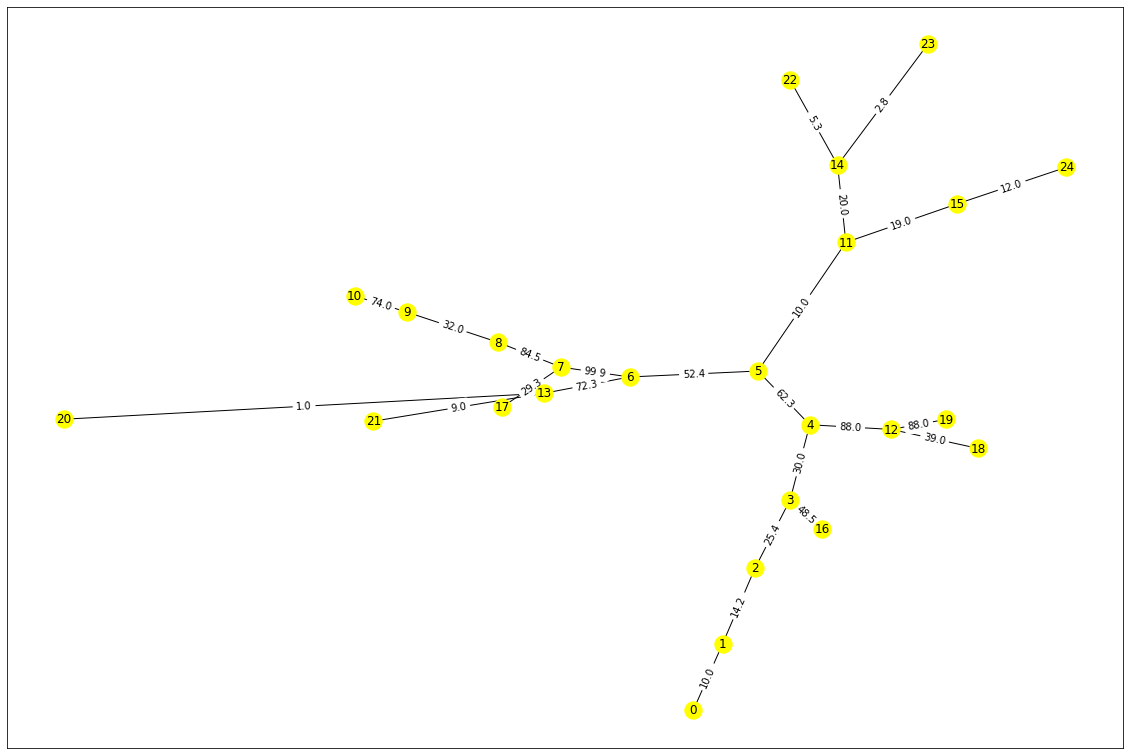

In [29]:

import networkx as nx
from parse import read_input_file, write_output_file, read_output_file
import utils
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import os
import sys
import matplotlib.pyplot as plt
import random
import numpy as np
from parse import read_input_file, write_output_file, read_output_file
path = 'outputs/small-3.out'
G = read_input_file('inputs/small-3.in')
#T = read_output_file(path, G)
fig = plt.figure(figsize=(20, 30))
fig.add_subplot(211)
pos = nx.spring_layout(G)

labels = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx(G, pos=pos, node_color='yellow')
#nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='red', edge_color='red')
#nx.draw_networkx(T, pos=pos, node_color='blue')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)